# MLP from Scratch — Implemented using PyTorch

This notebook walks through the construction of a multi-layer perceptron (MLP) from scratch using PyTorch-style objects, without using `nn.Module`. It mirrors ourearlier [micrograd build](\zero-to-hero\micrograd) but uses PyTorch tensors and automatic differentiation.

We build:
- A scalar neuron (with activation)
- A layer of neurons
- A fully connected MLP
- Parameter tracking for training

This notebook is part of the [`educational_notebooks`](/educational_notebooks) repo and is meant as a learning tool — not a production-ready model.

# The Multi-layer perceptron (MLP)

### Overview:

An *MLP* is one of the simplest machine learning models—made up of a few key building blocks: basic linear algebra (vector sums and matrix multiplication), a nonlinear activation function, and a mechanism for learning via backpropagation. By stacking layers of *neurons* (perceptrons) where each output depends on all inputs from the previous layer, we build what's called a **fully connected neural network**. Each operation we use is differentiable, which means we can not only pass data forward through the network but also compute how to adjust the model using gradients and optimization as we go through training data.

## 1. The perceptron (aka the neuron): 

We should just think of a perceptron (neuron) as a function that takes in many inputs and outputs a single number. Inside a neuron are a list of numbers (initially randomized and then updated as the model trains) called *weights*--one for each input to the neuron--and an optional bias (single number). The neuron takes in a list of numbers called the input in the form of a vector, multiplies each input with a weight and adds up all the results, then adds a bias to the result. This gives us a single number $z$, to which we can then apply a non-linear function $f$ to to get the output of the neuron $\hat{y}$.
> **Example**. Our input will be three dimensional: $x_1=4, x_2=8, x_3=7$. Our weights will be variables $w_1, w_2, w_3$ and bias $b$. The first step is to multiply all the inputs and weights together, take the sum and add a bias: $$x_1\cdot w_1 + x_2\cdot w_2 + x_3\cdot w_3 + b= \boxed{4w_1 + 8w_2 + 7w_3 + b = z}.$$ Note that the output $z$, resulting from the dot product of two vectors and addition is a single number. Lastly, we take some non-linear function $f$ and apply it to $z$. For this example we take the hyperbolic tangent $$f(x) = \tanh(x) = \frac{e^{2x}-1}{e^{2x}+1}$$ (where $e^x$ is the exponential function). This function outputs values between $-1$ and $1$, and so we think of the values close to $1$ as indicating a strong activation and values close to $-1$ as very little activation (for the neuron analogy anyways!). The end result, i.e. the output of this neuron will be
> $$ \hat{y} = \frac{e^{2z} - 1}{e^{2z} + 1} = f\left(\sum_{i=1}^3 (w_i\cdot x_i) + b\right)$$.

So, the neuron takes in many inputs (say $n$) and outputs a single number $\hat{y}$ which is generally the result of a specific function which introduces non-linearity. The reason for the *activation* function is that we wouldn't be able to model any non-linear data if we didn't have this function... everything would be the result of linear algebra (hence linear!)--even in a complicated model with many layers and MANY neurons--and so we really do need this for practical purposes. There are tons of options for this non-linear function and each has benefits/drawbacks: see [wikipedia](https://en.wikipedia.org/wiki/Activation_function) for more on activation functions. 

To implement a neuron using Pytorch we can run the following code (**Note**: *below we will implement a fully connected MLP using ```nn.Module``` which will be closer to production quality but this closely mirrors the 'from scratch' micrograd experiment so we include it first*):

```python
import torch

class Neuron:
    def __init__(self, nin, nonlin=True):
        self.w = torch.randn(nin, requires_grad=True)
        self.b = torch.randn(1,   requires_grad=True)
        self.nonlin = nonlin

    def __call__(self, x):
        y = x @ self.w + self.b
        return torch.tanh(y) if self.nonlin else y

    def parameters(self):
        return [self.w, self.b]
```

## 2. The layer:

**Key idea:** A *layer* is a collection of neurons that all receive the same input vector and independently compute their outputs.

Each neuron has its own set of weights and bias, and produces a single output like we outlined above. So, if a layer has $m$ neurons and receives an $n$-dimensional input, the output will be an $m$-dimensional vector. Here is a little sketch of the flow through a layer:

$$ \begin{align*}
    (x_1, x_2, \dots, x_n)  \rightarrow &\fbox{Layer}  \rightarrow  (\hat{y}_1, \hat{y}_2, \dots, \hat{y}_m)
    \end{align*}
$$
> **Example (continued):** Above we had a simple example of a neuron with $\tanh$ activation. To form a layer we can just link a few neurons together to produce an output. Let's use 2 neurons to keep things simple: each neuron has 3 weights and a bias and these will generally not be the same. We can add subscripts to distinguish between the weights and bias of each neuron:
    $$
        \begin{align*}
                n_1 : (w_{1,1},\; w_{1,2},\; w_{1,3},\;\; b_1) \\
                n_2 : (w_{2,1},\; w_{2,2},\; w_{2,3},\;\; b_2)
        \end {align*}
    $$
> so the first number represents that neuron and the second represents the weight in that neuron. Assuming the same inputs as the previous example, the result of this layer will be
    $$
        \begin{align*}
                \hat{y}_1 : \tanh(4w_{1,1} + 8w_{1,2} + 7w_{1,3} + b_1) = f\left( \sum_{i=1}^3 (w_{1,i}\cdot x_i ) + b_1\right) \\
                \hat{y}_2 : \tanh(4w_{2,1} + 8w_{2,2} + 7w_{2,3} + b_2) = f\left( \sum_{i=1}^3 (w_{2,i}\cdot x_i ) + b_2\right)
        \end {align*}
    $$
> or, using matrices/vectors we can write the weights, bias and input as:
    $$
    \begin{align*}
    W_1 = \begin{pmatrix} w_{1,1} & w_{1,2} & w_{1,3} \\ w_{2,1} & w_{2,2} & w_{2,3} \end{pmatrix}, 
    && B_1 = \begin{pmatrix} b_1 \\ b_2 \end{pmatrix}, 
    && X = \begin{pmatrix} 4 \\ 8 \\ 7 \end{pmatrix}.
    \end{align*}
    $$
> And using this, the operations of layer 1 can be written succinctly using linear algebra:
    $$ f\left( W_1\cdot X + B_1\right). $$

The notation that we used at the end of the example generalizes nicely to arbitrary dimensions. If there are $n$ inputs to the layer, and $m$ neurons in the layer then $W_1$ is a matrix (or array) with $m$-rows and $n$ columns, $X$ is a column vector (a 1-dimensional array) with $n$-rows, and $B_1$ is a column vector with $m$-rows. The activation function then applies to each row in the result $Y$ which is a column vector with $m$-rows (one for each neurons output):
    $$ f(W_1\cdot X + B_1) = f(Y) = \hat(Y). $$

Here is the code for a basic Layer class following our Micrograd format. This will call the Neuron class that we built in the previous section.

```python
class Layer:
    def __init__(self, nin, nout, activation='tanh'):
        self.neurons = [Neuron(nin, activation=activation) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters]
```

## 3. The Multi-Layer Perceptron:

An MLP is just a series of *fully connected* layers. The only requirement is that the output size of one layer matches the input size of the next—otherwise, the data can't flow forward.

Here’s a diagram of a simple MLP with 3 inputs, two hidden layers (with 4 and 6 neurons respectively), and a single output neuron:
> <img src="basic_mlp.png" style="width: 500px; height: 400px;">

And the scratch code calling our Layer class is as follows:

```python
class MLP:
    def __init__(self, nin, layers):
        sizes = [nin] + layers
        self.layers = [Layer(sizes[i], sizes[i+1], activation=True if i<len(sizes)-2 else False) for i in range(len(sizes)-1)]


    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters]
```

## 4. Training an MLP

### 4.1. How a Neuron Learns — Step-by-Step

**Step 1: Feedforward**  
The neuron computes a weighted sum of its inputs plus a bias term:  $z = w^\top x + b$ 
It then applies a nonlinear activation (e.g., `tanh`, `ReLU`) to produce the output:
        $$ \hat{y} = \text{activation}(z)$$

---

**Step 2: Compute the Loss**  
We compare the predicted output $\hat{y}$ to the actual label $y$ using a loss function that returns a scalar error.  
For example, with mean squared error:
$$
\mathcal{L} = (\hat{y} - y)^2
$$

---

**Step 3: Backpropagation**  
Using the chain rule from calculus, we compute the gradient of the loss with respect to each parameter — how much a small change in that parameter will affect the loss.  
In PyTorch, we call:

```python
loss.backward()
```

This fills `.grad` fields for each parameter with the respective gradient.

> 💡 The gradient points in the direction of steepest *increase* in loss. Since we want to minimize the loss, we step in the opposite direction.

---

**Step 4: Parameter Update (Gradient Descent)**  
We update weights and biases by subtracting a small portion (the learning rate \(\alpha\)) of the gradient:

$$
w_i = w_i - \alpha \frac{\partial \mathcal{L}}{\partial w_i}, \;\;\;\;\;\;
b = b - \alpha \frac{\partial \mathcal{L}}{\partial b}
$$

In PyTorch, this is done manually via:

```python
with torch.no_grad():
    for p in model.parameters():
        p -= alpha * p.grad
```

---

**Step 5: Repeat Over Epochs**  
This entire process is repeated across multiple data points and epochs. Over time, the parameters refine to minimize the loss across the training set.

---

**Recap**: The core learning loop in a neural network is:  
1. Forward pass  
2. Loss calculation  
3. Backward pass  
4. Parameter update  
5. Repeat  

Each step is built on calculus (gradients) and linear algebra (matrix ops), with PyTorch handling the complexity behind the scene.


## 5. Examples

### 5.1. Linear

#### 5.1.0. The model

In [956]:
import torch
import torch.nn as nn

class Neuron:
    def __init__(self, nin, activation=True):
        self.w = torch.randn(nin, requires_grad=True)
        self.b = torch.randn(1, requires_grad=True)
        self.activation = activation

    def __call__(self, x):
        # This is the only alteration from the above code which handles batching in the linear example below. Otherwise we must feed through one example at a time.
        z = x @ self.w.view(-1,1) + self.b
        return torch.tanh(z) if self.activation else z

    def parameters(self):
        return [self.w, self.b]


class Layer:
    def __init__(self, nin, nout, activation=True):
        self.neurons = [Neuron(nin, activation=activation) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else torch.stack(outs)
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, layers):
        sizes = [nin] + layers
        self.layers = [Layer(sizes[i], sizes[i+1], activation=True if i<len(sizes)-2 else False) for i in range(len(sizes)-1)]


    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

#### 5.1.1. training on linear data

In [959]:
###  Linear model: y = 4x - 3 ###
import matplotlib.pyplot as plt

# Data
xs = torch.tensor([[1.0], [3.0], [10.0], [7.0], [-4.0]])
ys = torch.tensor([[1.0], [9.0], [37.0], [25.0], [-19.0]])

test_xs = torch.tensor([[0.0], [8.5], [2.0], [-1.0]])
test_ys = torch.tensor([[-3.0], [31.0], [5.0], [-7.0]])



model = MLP(1, [1])
alpha = 0.01
epochs = 500
training_losses = []
test_losses = []


for epoch in range(epochs):    
    # Forward pass
    y_pred = model(xs)
    loss = ((y_pred - ys) ** 2).mean()
    
    # Zero gradients
    for p in model.parameters():
        if p.grad is not None:
            p.grad.zero_()
    
    # Backward
    loss.backward()
    
    # Update
    with torch.no_grad():
        for p in model.parameters():
            p.data -= alpha * p.grad

    # Test
    with torch.no_grad():
        y_test_pred = model(test_xs)
        test_loss = ((y_test_pred - test_ys) ** 2).mean()

    training_losses.append(loss.item())
    test_losses.append(test_loss.item())
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")



# Output the models prediction
m = model.layers[0].neurons[0].w.item()
b = model.layers[0].neurons[0].b.item()
print()
print(f'The predicted linear equation is: y= {m:.2f}x + {b:.2f}')

Epoch 0: loss = 302.0607
Epoch 50: loss = 2.4835
Epoch 100: loss = 0.6532
Epoch 150: loss = 0.1718
Epoch 200: loss = 0.0452
Epoch 250: loss = 0.0119
Epoch 300: loss = 0.0031
Epoch 350: loss = 0.0008
Epoch 400: loss = 0.0002
Epoch 450: loss = 0.0001

The predicted linear equation is: y= 4.00x + -3.00


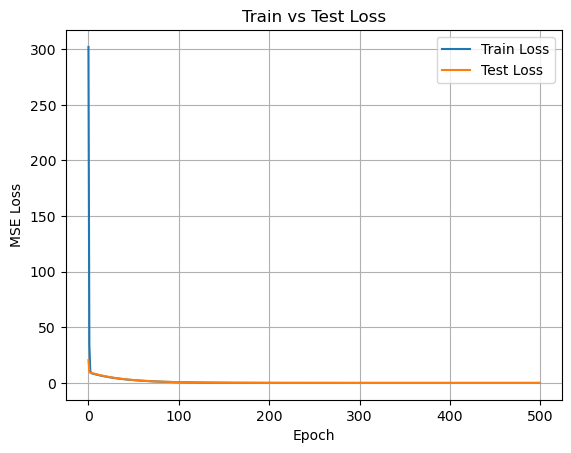

In [1003]:
plt.plot(training_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

### 5.2. XOR

#### 5.2.0. The model

In [965]:
import torch
import torch.nn as nn

class Neuron:
    def __init__(self, nin, activation=True):
        self.w = torch.randn(nin, requires_grad=True)
        self.b = torch.randn(1, requires_grad=True)
        self.activation = activation

    def __call__(self, x):
        z = x @ self.w + self.b
        return torch.tanh(z) if self.activation else z

    def parameters(self):
        return [self.w, self.b]


class Layer:
    def __init__(self, nin, nout, activation=True):
        self.neurons = [Neuron(nin, activation=activation) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return torch.stack(outs, dim=-1)
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, layers):
        sizes = [nin] + layers
        self.layers = [Layer(sizes[i], sizes[i+1], activation=True if i<len(sizes)-2 else False) for i in range(len(sizes)-1)]


    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

#### 5.2.1. Training on XOR

In [1008]:
# Data
xs = torch.tensor([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
ys = torch.tensor([[1.0], [0.0], [0.0], [1.0]])

model = MLP(2, [4,1])
loss_fn = nn.BCEWithLogitsLoss()
alpha = 0.03
epochs = 10000
losses = []

for epoch in range(epochs):
    zs = model(xs)
    loss = loss_fn(zs, ys)

    
    with torch.no_grad():
        for p in model.parameters():
            if p.grad is not None:
                p.grad.zero_()
    loss.backward()

    with torch.no_grad():
        for p in model.parameters():
            p.data -= alpha * p.grad

    losses.append(loss.item())
    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item():.2f}')

Epoch: 0, Loss: 0.76
Epoch: 1000, Loss: 0.32
Epoch: 2000, Loss: 0.10
Epoch: 3000, Loss: 0.05
Epoch: 4000, Loss: 0.03
Epoch: 5000, Loss: 0.02
Epoch: 6000, Loss: 0.02
Epoch: 7000, Loss: 0.01
Epoch: 8000, Loss: 0.01
Epoch: 9000, Loss: 0.01


In [1010]:
with torch.no_grad():
    preds = torch.sigmoid(model(xs))
    predicted = (preds > 0.5).float()
    acc = (predicted == ys).float().mean().item()
    print(f"\nFinal Accuracy: {acc:.2f}")
    for x, y_hat in zip(xs, predicted):
        print(f"Input: {x.tolist()}, Prediction: {y_hat.item():.0f}")


Final Accuracy: 1.00
Input: [0.0, 0.0], Prediction: 1
Input: [0.0, 1.0], Prediction: 0
Input: [1.0, 0.0], Prediction: 0
Input: [1.0, 1.0], Prediction: 1


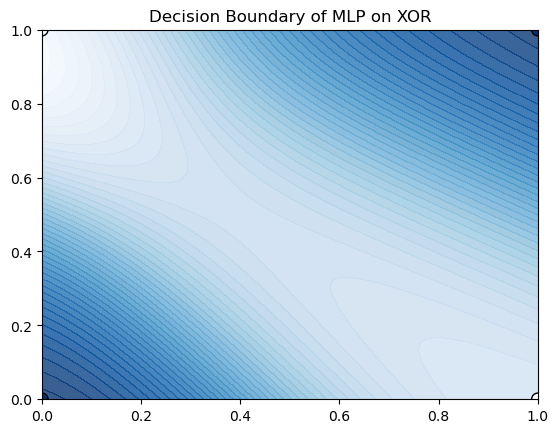

In [1012]:
import numpy as np

xx, yy = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 1, 100), indexing='ij')
grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)
with torch.no_grad():
    zz = model(grid).reshape(100, 100)

plt.contourf(xx, yy, zz.numpy(), levels=50, cmap="Blues", alpha=0.8)
plt.scatter(xs[:,0], xs[:,1], c=ys.squeeze(), edgecolors='k', cmap="Blues", s=80)
plt.title("Decision Boundary of MLP on XOR")
plt.show()

## 6: Implementation of an MLP using ```nn.Module```
In the sections above we outlined basic code for the Neuron, Layer, and a fully connected MLP which piggybacked on what we did in Micrograd. Here we ditch the direct analogue and outline some basic code for an multi-layer perceptron, utilizing ```nn.Module``` but still relying on a somewhat from scratch feel. 

This class defines a flexible MLP using PyTorch's `nn.Sequential`. You can control:
- The number and size of hidden layers via the `layers` list.
- The activation function applied after each layer.
- Whether to apply an activation to the output layer (default: yes unless `activation='none'`).

This makes it easy to construct both classifiers and regressors:
- For regression: `MLP(1, [1], activation='none')`
- For binary classification: `MLP(2, [10, 1], activation='sigmoid')`


```python 
import torch
import torch.nn as nn 

class MLP(nn.Module):
    def __init__(self, nin, layers, activation='relu'):
        super().__init__()
        act_map = {
            'relu': nn.ReLU,
            'tanh': nn.Tanh,
            'sigmoid': nn.Sigmoid,
            'none': nn.Identity
        }

        modules = []
        sizes = [nin] + layers
        for i in range(len(layers)):
            modules.append(nn.Linear(sizes[i], sizes[i+1]))
            if i < len(layers) - 1:
                modules.append(act_map[activation]())

        self.net = nn.Sequential(*modules)

    def forward(self, x):
        return self.net(x)
```

### 6.1 Examples (with ```nn.Module```)

#### 6.1.0. The model

In [1016]:
import torch
import torch.nn as nn 

class MLP(nn.Module):
    def __init__(self, nin, layers, activation='relu'):
        super().__init__()
        act_map = {
            'relu': nn.ReLU,
            'tanh': nn.Tanh,
            'sigmoid': nn.Sigmoid,
            'none': nn.Identity
        }

        modules = []
        sizes = [nin] + layers
        for i in range(len(layers)):
            modules.append(nn.Linear(sizes[i], sizes[i+1]))
            if i < len(layers) - 1:
                modules.append(act_map[activation]())

        self.net = nn.Sequential(*modules)

    def forward(self, x):
        return self.net(x)

#### 6.1.1. Linear

In [1018]:
###  Linear model: y = 4x - 3 ###
import matplotlib.pyplot as plt

# Data
xs = torch.tensor([[1.0], [3.0], [10.0], [7.0], [-4.0]])
ys = torch.tensor([[1.0], [9.0], [37.0], [25.0], [-19.0]])

test_xs = torch.tensor([[0.0], [8.5], [2.0], [-1.0]])
test_ys = torch.tensor([[-3.0], [31.0], [5.0], [-7.0]])



model = MLP(1, [1], activation='none')
alpha = 0.01
epochs = 500
training_losses = []
test_losses = []




for epoch in range(epochs):
    
    #------ training loop -------#
    model.train()
    
    # forward pass with mean squared error
    zs = model(xs)
    loss = (((zs - ys)**2).mean())

    # zero the gradients
    model.zero_grad()

    # backward pass
    loss.backward()

    # update parameters
    with torch.no_grad():
        for p in model.parameters():
            p.data -= alpha * p.grad

    #---------------------------#


    # ------- test loss -------- #
    model.eval()
    with torch.no_grad():
        y_test_pred = model(test_xs)
        test_loss = ((y_test_pred - test_ys) ** 2).mean()
    # ---------------------------# 

 
    # ------ loss tracking ------ #
    training_losses.append(loss.item())
    test_losses.append(test_loss.item())
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")
    # ----------------------------#

# Output the models prediction
m = model.net[0].weight.item()
b = model.net[0].bias.item()

print()
print(f'The predicted linear equation is: y= {m:.2f}x + {b:.2f}')

Epoch 0: loss = 718.5515
Epoch 50: loss = 2.5853
Epoch 100: loss = 0.6800
Epoch 150: loss = 0.1788
Epoch 200: loss = 0.0470
Epoch 250: loss = 0.0124
Epoch 300: loss = 0.0033
Epoch 350: loss = 0.0009
Epoch 400: loss = 0.0002
Epoch 450: loss = 0.0001

The predicted linear equation is: y= 4.00x + -3.00


#### 6.1.2. XOR

In [1021]:
# Data
xs = torch.tensor([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
ys = torch.tensor([[1.0], [0.0], [0.0], [1.0]])

model = MLP(2, [4,1], activation='tanh')
loss_fn = nn.BCEWithLogitsLoss()
alpha = 0.03
epochs = 10000
losses = []

for epoch in range(epochs):
    model.train()
    zs = model(xs)
    loss = loss_fn(zs, ys)

    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        for p in model.parameters():
            p.data -= alpha * p.grad

    losses.append(loss.item())
    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item():.2f}')

Epoch: 0, Loss: 0.71
Epoch: 1000, Loss: 0.66
Epoch: 2000, Loss: 0.36
Epoch: 3000, Loss: 0.09
Epoch: 4000, Loss: 0.05
Epoch: 5000, Loss: 0.03
Epoch: 6000, Loss: 0.02
Epoch: 7000, Loss: 0.02
Epoch: 8000, Loss: 0.01
Epoch: 9000, Loss: 0.01


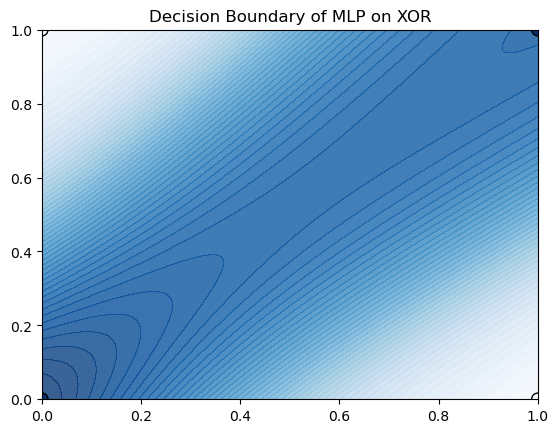

In [1023]:
import numpy as np

xx, yy = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 1, 100), indexing='ij')
grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)
with torch.no_grad():
    zz = model(grid).reshape(100, 100)

plt.contourf(xx, yy, zz.numpy(), levels=50, cmap="Blues", alpha=0.8)
plt.scatter(xs[:,0], xs[:,1], c=ys.squeeze(), edgecolors='k', cmap="Blues", s=80)
plt.title("Decision Boundary of MLP on XOR")
plt.show()

## Reflections & Next Steps

- Tanh seems to do better than ReLU on XOR. Possibly due to its smoothness and centered output.
- PyTorch makes experimentation fast and flexible — a big change from the same examples in micrograd.
- nn.Module let's us define one model that works in various settings. By scratch it is easy to run into errors due to size mismatches during batching.
- Add some additional experiments for each of the MLPs we defined and maybe do more side by side comparisons.

🚧 This notebook is intentionally simple. For interpretability tools (activation visualization, PCA, patching, etc.), see the upcoming repo: **`interpreting_toymodels`** (coming soon!).

📁 Part of the larger repo series (more to come): [ML Educational Series](/educational_notebooks)